# ENV ALL 환경 제작

In [14]:
from modules.env import Environment
from keras.models import load_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf

In [2]:
person_num = 10
target_id = None
env = Environment(person_num  = person_num, agent_num = 0,step = 100)
env.create_person(target_id)

In [39]:
state = env.reset()
actionsss = []
statess = []
stock_price_list = []
rewards = []
step_num = 1000


for i in range(10):
    env.person_dict[i].agent.model  = load_model('final_model_env/dqn_expert_{}_dense.h5'.format(i+1))


for step in tqdm(range(step_num)):
    person_action = []

    if step == 0: # 첫 주식 배분
        for person in env.person_dict.values():
            person.buy_first(30)
            
            
    for person,model_id in zip(env.person_dict.values(),range(len(env.person_dict.values()))): # 주문 생성 
        action = person.real_invest(state) # 거래소에 주문 진행 (시작시간) / 일반 사람들
        person_action.append(action)



    env.total_invest.append(env.invest_list)
    next_state, reward = env.invest() #거래소 거래 진행 (마감시간)
    env.save_person_information()
    stock_price_list.append(env.stock_price)




    statess.append(state)
    actionsss.append(person_action)
    
    state = [next_state]

    rewards.append(reward)
    
    

100%|███████████████████████████████████████| 1000/1000 [02:24<00:00,  6.91it/s]


# Reward model 데이터 추출

In [40]:
def min_max_scaling(values):
    min_value = min(values)
    max_value = max(values)
    
    scaled_values = [(value - min_value) / (max_value - min_value) for value in values]
    
    return scaled_values

In [41]:
min_max_scaling(rewards[-1])

[0.4026782450738288,
 0.10110430535094739,
 0.15724998061650844,
 0.40997751514681635,
 0.38905441777522143,
 0.034934594552687416,
 0.0,
 0.02875402899770741,
 0.5097526666149769,
 1.0]

In [42]:
data_x_1 = []
data_x_2 = []
data_y = []
# for state,actions in zip(statess[1:],actionsss[1:]):
#     for i in range(person_num):
#         test_rate = min_max_scaling(rewards[-1])
#         data_x_1.append(np.array(list(state[0][0]),dtype='float32'))
#         data_x_2.append(np.array(actions[i],dtype='float32'))
#         data_y.append([test_rate[i]])

        


scaled_rewards = min_max_scaling(rewards[-1])

# 모든 조합에 대해 비교
for state, actions in zip(statess[1:], actionsss[1:]):
    for i in range(person_num):
        for j in range(i+1, person_num):
            data_x_1.append(np.array(list(state[0][0]), dtype='float32'))
            data_x_2.append(np.array(actions[i], dtype='float32'))
            
            data_x_1.append(np.array(list(state[0][0]), dtype='float32'))
            data_x_2.append(np.array(actions[j], dtype='float32'))
            
            # test_rate를 기반으로 라벨을 생성
            if scaled_rewards[i] > scaled_rewards[j]:
                data_y.append([1.0])  # i가 j보다 크면
                data_y.append([0.0])
            else:
                data_y.append([0.0])
                data_y.append([1.0])  # j가 i보다 크거나 같으면


In [43]:
state_train, state_test, action_train, action_test, label_train, label_test = train_test_split(
    data_x_1, data_x_2, data_y, test_size=0.3,shuffle= True)

In [44]:
actions

[[0, 6, 8],
 [1, 0, 5],
 [1, 8, 1],
 [0, 0, 3],
 [0, 5, 4],
 [1, 6, 2],
 [2, 3, 6],
 [2, 9, 3],
 [2, 5, 7],
 [0, 7, 0]]

# Reward model 학습

In [76]:
from keras.layers import Dense, Input, Concatenate
state_dim = 37
action_dim = 3



# GAIL 모델 생성
state_input = Input(shape=(state_dim,), name='state_input')
x = Dense(64, activation='relu')(state_input)



action_input = Input(shape=(action_dim,), name='action_input')
xc = Dense(64, activation='relu')(action_input)



input_combined = Concatenate()([x, xc])


hidden_layer = Dense(128, activation='relu')(input_combined)
hidden_layer = Dense(64, activation='relu')(hidden_layer)
output_layer = Dense(1,activation='sigmoid')(hidden_layer)



In [77]:
discriminator = Model(inputs=[state_input, action_input], outputs=output_layer)




In [78]:
discriminator.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.legacy.Adam(), metrics=['accuracy'])

v = discriminator.fit([np.array(state_train),np.array(action_train)],np.array(label_train),validation_data = ([np.array(state_test),np.array(action_test)],np.array(label_test)) , epochs=512, batch_size=64)


Epoch 1/512
22/22 [==============================] - 0s 3ms/step - loss: 1859.1119 - accuracy: 0.4649 - val_loss: 69.9806 - val_accuracy: 0.5167
Epoch 2/512
22/22 [==============================] - 0s 1ms/step - loss: 1017.8832 - accuracy: 0.4835 - val_loss: 641.9701 - val_accuracy: 0.5083
Epoch 3/512
22/22 [==============================] - 0s 1ms/step - loss: 518.6537 - accuracy: 0.4857 - val_loss: 195.5346 - val_accuracy: 0.5083
Epoch 4/512
22/22 [==============================] - 0s 1ms/step - loss: 226.3432 - accuracy: 0.4843 - val_loss: 109.1136 - val_accuracy: 0.4917
Epoch 5/512
22/22 [==============================] - 0s 1ms/step - loss: 460.2268 - accuracy: 0.5043 - val_loss: 970.1797 - val_accuracy: 0.4917
Epoch 6/512
22/22 [==============================] - 0s 1ms/step - loss: 324.8187 - accuracy: 0.5000 - val_loss: 12.7056 - val_accuracy: 0.5050
Epoch 7/512
22/22 [==============================] - 0s 1ms/step - loss: 402.3956 - accuracy: 0.4886 - val_loss: 950.6907 - val_ac

22/22 [==============================] - 0s 1ms/step - loss: 14.3850 - accuracy: 0.6810 - val_loss: 17.5914 - val_accuracy: 0.5683
Epoch 58/512
22/22 [==============================] - 0s 1ms/step - loss: 12.2998 - accuracy: 0.6252 - val_loss: 9.0413 - val_accuracy: 0.6467
Epoch 59/512
22/22 [==============================] - 0s 1ms/step - loss: 35.8325 - accuracy: 0.5815 - val_loss: 5.9872 - val_accuracy: 0.7067
Epoch 60/512
22/22 [==============================] - 0s 1ms/step - loss: 62.1677 - accuracy: 0.5272 - val_loss: 21.7288 - val_accuracy: 0.5383
Epoch 61/512
22/22 [==============================] - 0s 1ms/step - loss: 28.6323 - accuracy: 0.5479 - val_loss: 33.9968 - val_accuracy: 0.4917
Epoch 62/512
22/22 [==============================] - 0s 1ms/step - loss: 33.5173 - accuracy: 0.5322 - val_loss: 40.5095 - val_accuracy: 0.5083
Epoch 63/512
22/22 [==============================] - 0s 1ms/step - loss: 37.8080 - accuracy: 0.5043 - val_loss: 26.7056 - val_accuracy: 0.5233
Epoch 6

22/22 [==============================] - 0s 1ms/step - loss: 7.4115 - accuracy: 0.7232 - val_loss: 18.4254 - val_accuracy: 0.5550
Epoch 115/512
22/22 [==============================] - 0s 1ms/step - loss: 28.1817 - accuracy: 0.5680 - val_loss: 68.3494 - val_accuracy: 0.5083
Epoch 116/512
22/22 [==============================] - 0s 1ms/step - loss: 47.5341 - accuracy: 0.5451 - val_loss: 46.7244 - val_accuracy: 0.5083
Epoch 117/512
22/22 [==============================] - 0s 1ms/step - loss: 26.5556 - accuracy: 0.5672 - val_loss: 9.0497 - val_accuracy: 0.6533
Epoch 118/512
22/22 [==============================] - 0s 1ms/step - loss: 15.9219 - accuracy: 0.6245 - val_loss: 36.8545 - val_accuracy: 0.4917
Epoch 119/512
22/22 [==============================] - 0s 1ms/step - loss: 21.9937 - accuracy: 0.5973 - val_loss: 29.2605 - val_accuracy: 0.4917
Epoch 120/512
22/22 [==============================] - 0s 1ms/step - loss: 9.9541 - accuracy: 0.6974 - val_loss: 5.8275 - val_accuracy: 0.7450
Epo

22/22 [==============================] - 0s 1ms/step - loss: 4.9717 - accuracy: 0.7253 - val_loss: 5.5875 - val_accuracy: 0.6883
Epoch 172/512
22/22 [==============================] - 0s 1ms/step - loss: 8.3562 - accuracy: 0.6810 - val_loss: 8.0300 - val_accuracy: 0.7133
Epoch 173/512
22/22 [==============================] - 0s 1ms/step - loss: 8.5258 - accuracy: 0.6774 - val_loss: 8.4718 - val_accuracy: 0.6350
Epoch 174/512
22/22 [==============================] - 0s 1ms/step - loss: 6.4336 - accuracy: 0.7046 - val_loss: 4.6182 - val_accuracy: 0.7500
Epoch 175/512
22/22 [==============================] - 0s 1ms/step - loss: 6.4088 - accuracy: 0.7246 - val_loss: 4.8332 - val_accuracy: 0.7400
Epoch 176/512
22/22 [==============================] - 0s 1ms/step - loss: 8.9655 - accuracy: 0.6574 - val_loss: 4.8345 - val_accuracy: 0.7067
Epoch 177/512
22/22 [==============================] - 0s 1ms/step - loss: 7.6868 - accuracy: 0.6867 - val_loss: 9.6837 - val_accuracy: 0.6867
Epoch 178/512

22/22 [==============================] - 0s 1ms/step - loss: 4.9230 - accuracy: 0.6981 - val_loss: 3.5725 - val_accuracy: 0.7150
Epoch 229/512
22/22 [==============================] - 0s 1ms/step - loss: 12.0475 - accuracy: 0.6252 - val_loss: 5.1092 - val_accuracy: 0.7567
Epoch 230/512
22/22 [==============================] - 0s 1ms/step - loss: 10.5678 - accuracy: 0.6066 - val_loss: 12.6918 - val_accuracy: 0.5683
Epoch 231/512
22/22 [==============================] - 0s 1ms/step - loss: 8.2886 - accuracy: 0.6359 - val_loss: 4.3854 - val_accuracy: 0.6783
Epoch 232/512
22/22 [==============================] - 0s 1ms/step - loss: 8.5123 - accuracy: 0.6459 - val_loss: 7.6788 - val_accuracy: 0.5833
Epoch 233/512
22/22 [==============================] - 0s 1ms/step - loss: 7.4611 - accuracy: 0.6652 - val_loss: 6.5550 - val_accuracy: 0.6917
Epoch 234/512
22/22 [==============================] - 0s 1ms/step - loss: 7.9931 - accuracy: 0.6602 - val_loss: 3.3901 - val_accuracy: 0.7500
Epoch 235/

22/22 [==============================] - 0s 1ms/step - loss: 3.3965 - accuracy: 0.7182 - val_loss: 2.2838 - val_accuracy: 0.7500
Epoch 286/512
22/22 [==============================] - 0s 1ms/step - loss: 3.1109 - accuracy: 0.7067 - val_loss: 9.9565 - val_accuracy: 0.4983
Epoch 287/512
22/22 [==============================] - 0s 1ms/step - loss: 7.7664 - accuracy: 0.5837 - val_loss: 12.4130 - val_accuracy: 0.5083
Epoch 288/512
22/22 [==============================] - 0s 1ms/step - loss: 4.1035 - accuracy: 0.6931 - val_loss: 2.3543 - val_accuracy: 0.7083
Epoch 289/512
22/22 [==============================] - 0s 1ms/step - loss: 2.8422 - accuracy: 0.7210 - val_loss: 2.2448 - val_accuracy: 0.7367
Epoch 290/512
22/22 [==============================] - 0s 1ms/step - loss: 5.1990 - accuracy: 0.6488 - val_loss: 3.4815 - val_accuracy: 0.6417
Epoch 291/512
22/22 [==============================] - 0s 1ms/step - loss: 4.5316 - accuracy: 0.6788 - val_loss: 2.7136 - val_accuracy: 0.7817
Epoch 292/51

22/22 [==============================] - 0s 1ms/step - loss: 2.0677 - accuracy: 0.6989 - val_loss: 1.4209 - val_accuracy: 0.7517
Epoch 343/512
22/22 [==============================] - 0s 1ms/step - loss: 1.8671 - accuracy: 0.7253 - val_loss: 2.5749 - val_accuracy: 0.6283
Epoch 344/512
22/22 [==============================] - 0s 1ms/step - loss: 2.2759 - accuracy: 0.7003 - val_loss: 1.9784 - val_accuracy: 0.6650
Epoch 345/512
22/22 [==============================] - 0s 1ms/step - loss: 1.7519 - accuracy: 0.7132 - val_loss: 2.3930 - val_accuracy: 0.7350
Epoch 346/512
22/22 [==============================] - 0s 1ms/step - loss: 3.1043 - accuracy: 0.6516 - val_loss: 1.5543 - val_accuracy: 0.7717
Epoch 347/512
22/22 [==============================] - 0s 1ms/step - loss: 2.1422 - accuracy: 0.7060 - val_loss: 1.5499 - val_accuracy: 0.6933
Epoch 348/512
22/22 [==============================] - 0s 1ms/step - loss: 1.6017 - accuracy: 0.7246 - val_loss: 2.2153 - val_accuracy: 0.6333
Epoch 349/512

22/22 [==============================] - 0s 1ms/step - loss: 1.0947 - accuracy: 0.7110 - val_loss: 0.8011 - val_accuracy: 0.7633
Epoch 400/512
22/22 [==============================] - 0s 1ms/step - loss: 0.9608 - accuracy: 0.7418 - val_loss: 1.1775 - val_accuracy: 0.7633
Epoch 401/512
22/22 [==============================] - 0s 1ms/step - loss: 0.9700 - accuracy: 0.7210 - val_loss: 0.8132 - val_accuracy: 0.7050
Epoch 402/512
22/22 [==============================] - 0s 1ms/step - loss: 0.9122 - accuracy: 0.7303 - val_loss: 0.7475 - val_accuracy: 0.7083
Epoch 403/512
22/22 [==============================] - 0s 1ms/step - loss: 0.9766 - accuracy: 0.7332 - val_loss: 1.2568 - val_accuracy: 0.6433
Epoch 404/512
22/22 [==============================] - 0s 1ms/step - loss: 4.6358 - accuracy: 0.6202 - val_loss: 39.6068 - val_accuracy: 0.4917
Epoch 405/512
22/22 [==============================] - 0s 1ms/step - loss: 23.5783 - accuracy: 0.5165 - val_loss: 51.8151 - val_accuracy: 0.4917
Epoch 406/

22/22 [==============================] - 0s 1ms/step - loss: 0.6896 - accuracy: 0.6252 - val_loss: 0.5621 - val_accuracy: 0.7183
Epoch 457/512
22/22 [==============================] - 0s 1ms/step - loss: 0.5802 - accuracy: 0.6974 - val_loss: 0.5440 - val_accuracy: 0.7383
Epoch 458/512
22/22 [==============================] - 0s 1ms/step - loss: 0.6656 - accuracy: 0.6252 - val_loss: 0.6030 - val_accuracy: 0.6100
Epoch 459/512
22/22 [==============================] - 0s 1ms/step - loss: 0.6803 - accuracy: 0.6152 - val_loss: 0.5627 - val_accuracy: 0.7550
Epoch 460/512
22/22 [==============================] - 0s 1ms/step - loss: 0.7313 - accuracy: 0.5937 - val_loss: 0.5398 - val_accuracy: 0.7633
Epoch 461/512
22/22 [==============================] - 0s 1ms/step - loss: 0.6034 - accuracy: 0.6795 - val_loss: 0.6023 - val_accuracy: 0.6017
Epoch 462/512
22/22 [==============================] - 0s 1ms/step - loss: 0.6058 - accuracy: 0.6502 - val_loss: 0.5421 - val_accuracy: 0.7600
Epoch 463/512

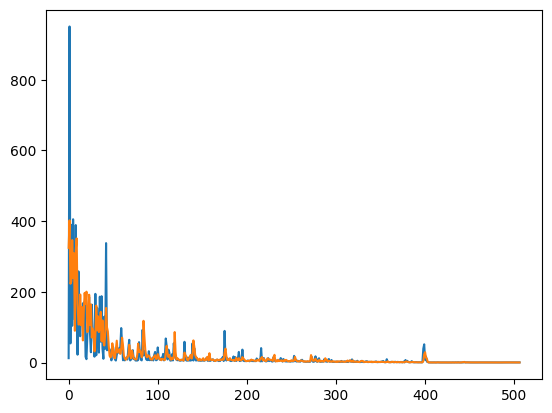

In [84]:
plt.plot(v.history['val_loss'][5:])
plt.plot(v.history['loss'][5:])